In [5]:
pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 sympy==1.11.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/1

In [41]:
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
import xml.etree.ElementTree as ET
import numpy as np

# Verificar si GPU está disponible
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Directorios
DATASET_DIR = '/content/drive/MyDrive/sis421/datasetDetection'
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VAL_DIR = os.path.join(DATASET_DIR, 'val')
ANNOTATIONS_DIR = os.path.join(DATASET_DIR, 'annotations')



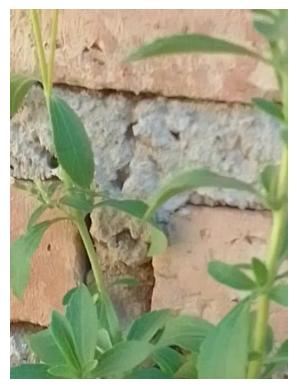

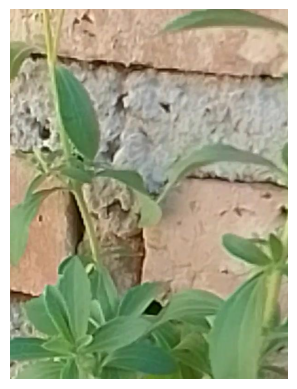

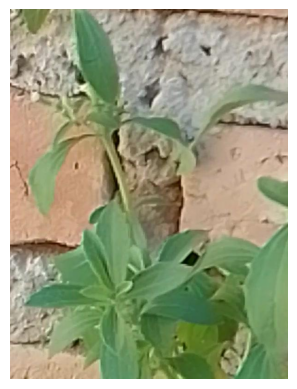

In [42]:
import matplotlib.pyplot as plt
from PIL import Image
import os
def show_images(folder, num_images=5):
    """
    Muestra un número limitado de imágenes de una carpeta.
    """
    images = os.listdir(folder)[:num_images]  # Obtener los nombres de las primeras imágenes
    for img_name in images:
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert("RGB")

        # Mostrar la imagen
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# Ejemplo: Mostrar imágenes de la carpeta "calendula"
show_images(os.path.join(TRAIN_DIR, 'stevia'), num_images=3)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
def parse_custom_annotation(annotation_path):
    # Leer el archivo JSON
    with open(annotation_path, 'r') as f:
        data = json.load(f)

    boxes = []
    labels = []

    # Diccionario para mapear las etiquetas a números
    label_map = {
        'calendula': 0,
        'stevia': 1,
        'locoto': 2,
        'malandre': 3,
        'lavanda': 4
    }

    # Recorrer las regiones y extraer las cajas y las etiquetas
    for region in data['regions']:
        # Extraer la caja delimitadora
        bounding_box = region['boundingBox']
        xmin = bounding_box['left']
        ymin = bounding_box['top']
        xmax = xmin + bounding_box['width']
        ymax = ymin + bounding_box['height']

        if xmax - xmin <= 0 or ymax - ymin <= 0:
            print(f"Ignorando caja inválida: {xmin}, {ymin}, {xmax}, {ymax}")
            continue  # Saltar a la siguiente región

        boxes.append([xmin, ymin, xmax, ymax])

        # Obtener la etiqueta
        label = label_map.get(region['tags'][0], -1)  # Tomar la primera etiqueta
        labels.append(label)

    return boxes, labels





In [44]:
#DEFINIR EL DATASET PERSONALIZADO

import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class PlantDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir

        # Recorrer subcarpetas y recopilar todas las imágenes
        self.image_files = []
        for root, _, files in os.walk(images_dir):  # Explora subcarpetas
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):  # Solo imágenes
                    self.image_files.append(os.path.join(root, file))

        # Recopilar todas las anotaciones
        self.annotation_files = sorted(
            f for f in os.listdir(annotations_dir)
            if f.endswith('.json') and not f.endswith('.vott')  # Ignorar .vott
        )

        # Verificar correspondencia por nombre base y filtrar anotaciones inválidas
        self.image_files, self.annotation_files = self._filter_valid_annotations()

        if not self.image_files or not self.annotation_files:
            raise ValueError("No se encontraron imágenes o anotaciones válidas.")

    def _filter_valid_annotations(self):
        filtered_images = []
        filtered_annotations = []

        for img_file, annotation_file in zip(sorted(self.image_files), sorted(self.annotation_files)):
            annotation_path = os.path.join(self.annotations_dir, annotation_file)
            with open(annotation_path, 'r') as f:
                annotation = json.load(f)
                # Verificar si existen "regions" y si no están vacías
                if "regions" in annotation and annotation["regions"]:
                    filtered_images.append(img_file)
                    filtered_annotations.append(annotation_file)

        return filtered_images, filtered_annotations

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Cargar imagen
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")

        # Cargar anotación correspondiente
        annotation_file = self.annotation_files[idx]
        annotation_path = os.path.join(self.annotations_dir, annotation_file)
        boxes, labels = parse_custom_annotation(annotation_path)

        # Convertir a tensores
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target




In [6]:
#train_dataset = PlantDataset(TRAIN_DIR, ANNOTATIONS_DIR, transforms=get_transform(train=True))
#print(f"Cantidad de datos de entrenamiento: {len(train_dataset)}")

#val_dataset = PlantDataset(VAL_DIR, ANNOTATIONS_DIR, transforms=get_transform(train=False))
#print(f"Cantidad de datos de validación: {len(val_dataset)}")


NameError: name 'get_transform' is not defined

In [45]:
#TRANSFORMACIONES Y DATALOADER

from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip

def get_transform(train=True):
    #transforms = [ToTensor()]
    #if train:
        #transforms.append(RandomHorizontalFlip(0.5))
    #return Compose(transforms)
    return ToTensor()

# Inicializar datasets
train_dataset = PlantDataset(TRAIN_DIR, ANNOTATIONS_DIR, transforms=get_transform(train=True))
val_dataset = PlantDataset(VAL_DIR, ANNOTATIONS_DIR, transforms=get_transform(train=False))

# Cargar datos
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [46]:
#CONFIGURAR EL MODELO PRE ENTRENADO

from torchvision.models.detection import fasterrcnn_resnet50_fpn

def get_model(num_classes):
    # Cargar modelo preentrenado
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # Reemplazar el predictor para nuestras clases
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Número de clases (5 plantas + 1 de fondo)
num_classes = 6
model = get_model(num_classes)
model.to(device)



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
#ENTRENAMIENTO

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Calcular pérdidas
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        # Actualizar gradientes
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {total_loss / len(data_loader)}")


# Entrenar
for epoch in range(1):  # 10 épocas
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()



In [ ]:
@torch.no_grad()
def evaluate_simple(model, data_loader, device, threshold=0.5):
    model.eval()
    total_loss = 0
    total_images = 0
    total_correct = 0
    total_predictions = 0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass y pérdidas
        outputs = model(images)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        # Evaluación métrica: conteo de predicciones correctas
        for i, output in enumerate(outputs):
            pred_boxes = output["boxes"]
            pred_scores = output["scores"]
            pred_labels = output["labels"]

            # Filtrar predicciones con puntuaciones altas
            keep = pred_scores > threshold
            pred_boxes = pred_boxes[keep]
            pred_labels = pred_labels[keep]

            # Verificar coincidencias con las anotaciones
            true_boxes = targets[i]["boxes"]
            true_labels = targets[i]["labels"]

            # Métrica simple: conteo de etiquetas correctas
            for label in pred_labels:
                if label in true_labels:
                    total_correct += 1

            total_predictions += len(pred_labels)
        total_images += len(images)

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_predictions if total_predictions > 0 else 0.0

    print(f"Evaluación: Pérdida Promedio = {avg_loss:.4f}, Precisión = {accuracy:.4f}")
    return avg_loss, accuracy


In [ ]:
#PERDIDAS
train_losses = []
val_losses = []

def train_one_epoch_with_losses(model, optimizer, data_loader, device, epoch):
    model.train()
    epoch_loss = 0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Calcular pérdida
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(data_loader)
    train_losses.append(avg_loss)
    print(f"Época {epoch}: Pérdida Entrenamiento = {avg_loss:.4f}")

for epoch in range(10):
    train_one_epoch_with_losses(model, optimizer, train_loader, device, epoch)
    val_loss, _ = evaluate_simple(model, val_loader, device)
    val_losses.append(val_loss)


In [ ]:
torch.save(model.state_dict(), "plant_detection_model.pth")
print("Modelo guardado como 'plant_detection_model.pth'")



In [2]:
#TESTEAR CON IMAGEN NUEVO
from torchvision.transforms import functional as F

def load_image(image_path):
    """Cargar y transformar una imagen para el modelo."""
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convertir a tensor y agregar una dimensión batch
    return image, image_tensor

def predict(model, image_tensor, device, threshold=0.5):
    """Realizar predicciones en una imagen."""
    model.eval()
    image_tensor = image_tensor.to(device)
    outputs = model(image_tensor)[0]  # Predicciones para la primera (y única) imagen
    # Filtrar por puntuación
    scores = outputs["scores"].detach().cpu().numpy()
    boxes = outputs["boxes"].detach().cpu().numpy()
    labels = outputs["labels"].detach().cpu().numpy()
    keep = scores >= threshold
    return boxes[keep], labels[keep], scores[keep]

def visualize_new_image(image, boxes, labels, scores, classes=None):
    """Visualizar predicciones en una imagen."""
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        label = classes[labels[i]] if classes else labels[i]
        ax.text(
            x_min, y_min - 10, f'{label}: {scores[i]:.2f}',
            color='red', fontsize=12,
            bbox=dict(facecolor='white', alpha=0.5)
        )
    plt.axis('off')
    plt.show()

# Ruta de una nueva imagen
new_image_path = "ruta/a/tu/imagen/nueva.jpg"

# Cargar y predecir
image, image_tensor = load_image(new_image_path)
boxes, labels, scores = predict(model, image_tensor, device, threshold=0.7)

# Visualizar resultados
class_names = ["Background", "Calendula", "Stevia", "Locoto", "Malamdre", "Lavanda"]
visualize_new_image(image, boxes, labels, scores, classes=class_names)


KeyboardInterrupt: 